In [1]:
# Affan Shoukat, Yale University 
# Estimating population herd immunity in the United States
# Final numbers be differ slightly in manuscript and if running this notebook due to stochasticity and random number generators

# Options: set env variable JULIA_NUM_THREADS to use multithreading for speeding up simulations

using Distributions
using Random
using Gnuplot
using Statistics
using CSV 
using DataFrames
using PrettyTables
using Dates
using StatsBase
using Base.Threads
# set a default Gnuplot/Jupyter set size here 
Gnuplot.options.mime[MIME"text/html"] = "svg enhanced standalone mouse size 650,400";
# check number of threads
Threads.nthreads()


8

In [2]:
# define constant distributions
#const ifr_tdd_distr = Truncated(LogNormal(log(13.2), 0.24), -Inf, 75)
const ifr_tdd_distr = Truncated(Gamma(3.385, 1/0.21), -Inf, 75)
const ift_inc_distr = Truncated(LogNormal(1.434, 0.661), -Inf, 25)
const ifr_distr = (LogNormal(log(0.002), 0.15), LogNormal(log(0.006), 0.18), LogNormal(log(0.03), 0.12), LogNormal(log(0.08), 0.09), LogNormal(log(0.15), 0.08), LogNormal(log(0.6), 0.078), LogNormal(log(2.2),  0.09), LogNormal(log(5.1),  0.118), LogNormal(log(9.3), 0.142))
const pdeaths = (0.04/100, 0.06/100, 0.9/100, 2/100, 5/100, 12/100, 21/100, 24/100, 35/100)

# test the maximum of tdd + inc, should not exceed 100 days for stability purposes. 
_tddlagvals = rand(ifr_tdd_distr, 10000) .+ rand(ift_inc_distr, 10000) 
length(findall(x -> x >= 100, _tddlagvals)) != 0 && error("lag+incubation > 100")

false

517×4 DataFrame
 Row │ Date        t      Cases  DailyDeaths 
     │ Date        Int64  Int64  Int64       
─────┼───────────────────────────────────────
   1 │ 2020-01-21      1      1            0
   2 │ 2020-01-22      2      0            0
   3 │ 2020-01-23      3      0            0
   4 │ 2020-01-24      4      1            0
   5 │ 2020-01-25      5      1            0
   6 │ 2020-01-26      6      2            0
   7 │ 2020-01-27      7      0            0
   8 │ 2020-01-28      8      0            0
   9 │ 2020-01-29      9      0            0
  10 │ 2020-01-30     10      1            0
  11 │ 2020-01-31     11      1            0
  ⋮  │     ⋮         ⋮      ⋮         ⋮
 508 │ 2021-06-11    508  26006          730
 509 │ 2021-06-12    509   8314          170
 510 │ 2021-06-13    510   4916           95
 511 │ 2021-06-14    511  12823          145
 512 │ 2021-06-15    512  10655          382
 513 │ 2021-06-16    513  14481          424
 514 │ 2021-06-17    514  12131          

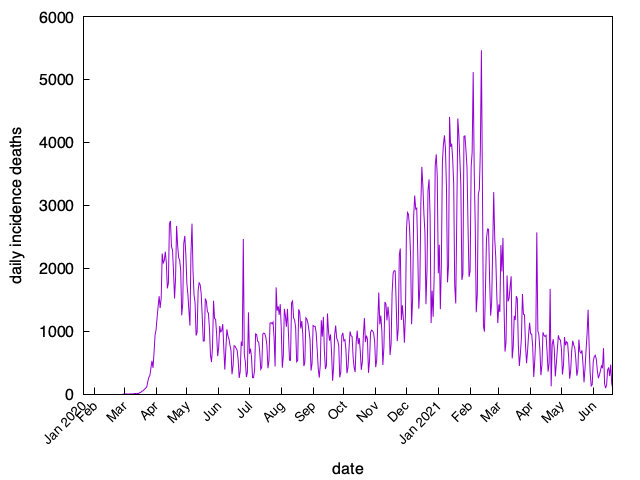

In [4]:
## read and plot the data file
df = DataFrame(CSV.File("USData.csv"))
#df.Date = Date.(df.Date, DateFormat("m/d/y"))
show(df)

@gp "reset" 
@gp :- "set xlabel 'date'"
@gp :- "set ylabel 'daily incidence deaths'"
@gp :- "set xtics ('Jan 2020' 1, 'Feb' 12, 'Mar' 41, 'Apr' 72, 'May' 102, 'Jun' 133, 'Jul' 163, 'Aug' 194, 'Sep' 225, 'Oct' 255, 'Nov' 286, 'Dec' 316, 'Jan 2021' 347, 'Feb' 378, 'Mar' 406, 'Apr' 437, 'May' 467, 'Jun' 498 )"
@gp :- "set xtics rotate by 45 right in font ', 10'"
@gp :- "set xtics noenhanced nomirror" # no escaping for strings :-
@gp :- "set ytics nomirror" :-
@gp :- 1:length(df.DailyDeaths) df.DailyDeaths "with lines notitle"


In [5]:
# Main simulation function: Runs MC simulations and in each simulation, samples IFR, calculate infections, and calculate lag-times
function run_sims() 
    # get minimum/maximum dates 
    datevec = collect((df.Date[1] - Day(100)):Day(1):df.Date[end])
    totalsims = 500
    resdf = Array{DataFrame, 1}(undef, totalsims) # create new dataframe to store the results    
    
    Threads.@threads for nsim in 1:totalsims
        res = DataFrame([:date => datevec, :deaths => 0, :sim => 0]) # create empty dataframe
        # for each row 
        lagarr = Array{Vector{Date}, 1}(undef, nrow(df))
        for (i, drow) in enumerate(eachrow(df))
            dths = drow[:DailyDeaths]
            ldate = drow[:Date]
            incs = rand(ift_inc_distr, dths) # sample incubation periods
            lags = rand(ifr_tdd_distr, dths) # sample tdd periods   
            lags = Int.(round.(lags .+ incs)) # add them together, round, convert to integer

            lagdates = ldate .- Dates.Day.(lags) # distribute the deaths to infection in previous days
            lagarr[i] = lagdates
            #lagarr[i] = StatsBase.countmap(lagdates) # sum up infections on same day
        end 

        _distdeaths = countmap(vcat(lagarr...))  # the dictionary of dates
        for dr in res.date        # res.date is the full date list from the minimum to maximum    
            if !(haskey(_distdeaths, dr))
                _distdeaths[dr] = 0 
            end
        end
 
        distdeaths = sort(_distdeaths)
        res.deaths .= values(distdeaths) # add to the dataframe
        res.sim .= nsim
        # calculate infections using sampled ifr
        samp_ifrs = pdeaths ./ (rand.(ifr_distr) ./ 100)
        agcolnames = [:ag1, :ag2, :ag3, :ag4, :ag5, :ag6, :ag7, :ag8, :ag9]
        transform!(res, [:deaths] => ByRow((dth) -> dth .* samp_ifrs) => agcolnames) # convert to per 100000
        res[!, :totalinfections] .= sum.(eachrow(res[:, 4:12]))
        resdf[nsim] = res
    end
    finaldf = vcat(resdf...)
end

# equivalent function, but very unoptimized function - takes very long to run, use above function 
function run_sims2() 
    # get minimum/maximum dates 
    datevec = collect((df.Date[1] - Day(100)):Day(1):df.Date[end])
    agcolnames = [:ag1, :ag2, :ag3, :ag4, :ag5, :ag6, :ag7, :ag8, :ag9]
    totalsims = 10
    resdf = Array{DataFrame, 1}(undef, totalsims) # create new dataframe to store the results    
    
    Threads.@threads for nsim in 1:totalsims        
        res = DataFrame([:date => datevec, :ag1 => 0, :ag2 => 0, :ag3 => 0, :ag4 => 0, :ag5 => 0, :ag6 => 0, :ag7 => 0, :ag8 => 0, :ag9 => 0, :sim => 0]) # create empty dataframe
        lagarr = Array{Vector{Date}, 2}(undef, nrow(df), 9) # for each row 
        for (i, drow) in enumerate(eachrow(df))
            dths = drow[:DailyDeaths]
            ldate = drow[:Date]
            
            samp_ifrs = pdeaths ./ (rand.(ifr_distr) ./ 100)
            totalinfecs = Int.(round.(dths .* samp_ifrs))
            
            for ag = 1:9 
                incs = rand(ift_inc_distr, totalinfecs[ag]) # sample incubation periods
                lags = rand(ifr_tdd_distr, totalinfecs[ag]) # sample tdd periods   
                lags = Int.(round.(lags .+ incs)) # add them together, round, convert to integer
                lagdates = ldate .- Dates.Day.(lags) # distribute the deaths to infection in previous days
                lagarr[i, ag] = lagdates 
            end
        end 
    
        for (xcol, ag) in zip(eachcol(lagarr), agcolnames) 
            _distdeaths = countmap(vcat(xcol...))  # the dictionary of dates
            for dr in res.date                     # res.date is the full date list from the minimum to maximum    
                if !(haskey(_distdeaths, dr))
                    _distdeaths[dr] = 0 
                end
            end
            distdeaths = sort(_distdeaths)
            res[!, ag] .= values(distdeaths)
            res[!, :sim] .= nsim
        end        
        res[!, :totalinfections] .= sum.(eachrow(res[:, 2:10]))
        resdf[nsim] = res
    end
    finaldf = vcat(resdf...)
end

run_sims2 (generic function with 1 method)

In [6]:
# run the simulations, about 2 minutes on i7 4 core, 8 thread
@time finaldf = run_sims()

120.935803 seconds (30.05 M allocations: 12.448 GiB, 2.21% gc time, 9.86% compilation time)


,date,deaths,sim,ag1,ag2,ag3,ag4,ag5,ag6
,Date,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,2019-10-13,0,1,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-10-14,0,1,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-10-15,0,1,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-10-16,0,1,0.0,0.0,0.0,0.0,0.0,0.0
5,2019-10-17,0,1,0.0,0.0,0.0,0.0,0.0,0.0
6,2019-10-18,0,1,0.0,0.0,0.0,0.0,0.0,0.0
7,2019-10-19,0,1,0.0,0.0,0.0,0.0,0.0,0.0
8,2019-10-20,0,1,0.0,0.0,0.0,0.0,0.0,0.0
9,2019-10-21,0,1,0.0,0.0,0.0,0.0,0.0,0.0


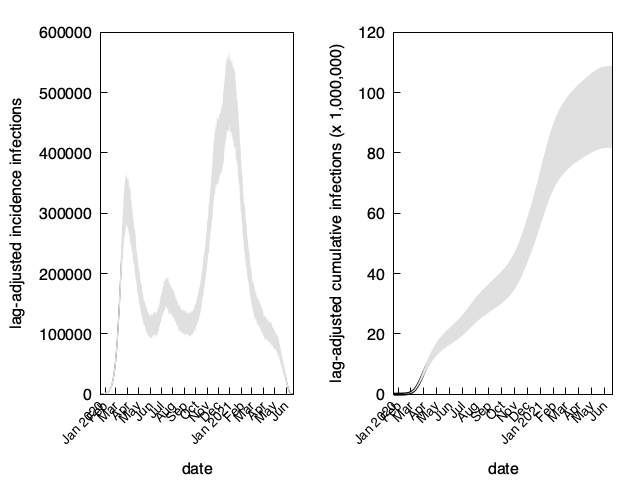

In [8]:
# take the mean of simulations, per day and plot the data
mean_inf_df = combine(groupby(finaldf, [:date]), :totalinfections => (x -> (mean=mean(x), min=minimum(x), max=maximum(x))) => AsTable)  

# plot the mean lag-adjsuted infections 
Gnuplot.options.mime[MIME"text/html"] = "svg enhanced standalone mouse size 1200,400";
@gp "reset" 
@gp :- "set multiplot layout 1,2 title ''"
@gp :- "set xlabel 'date'"

@gp :- "set xtics ('Jan 2020' 1, 'Feb' 12, 'Mar' 41, 'Apr' 72, 'May' 102, 'Jun' 133, 'Jul' 163, 'Aug' 194, 'Sep' 225, 'Oct' 255, 'Nov' 286, 'Dec' 316, 'Jan 2021' 347, 'Feb' 378, 'Mar' 406, 'Apr' 437, 'May' 467, 'Jun' 498 )"
@gp :- "set xtics rotate by 45 right in font ', 10'"
@gp :- "set xtics noenhanced nomirror" # no escaping for strings :-
@gp :- "set ytics nomirror" :-
# for computing lag times, we went back 100 days to make sure there is room for infections to be distributed. 
# but for plotting purposes we don't really need it. 
xvals = 1:(nrow(mean_inf_df) - 100)
ymeans, ymins, ymax = (mean_inf_df.mean[101:end], mean_inf_df.min[101:end], mean_inf_df.max[101:end])
#length(xvals)
#length(mean_inf_df.mean[101:end])

@gp :- 1 xvals ymeans "with lines notitle lc 'black'"
@gp :- 1 xvals ymins ymax "with filledcurves notitle fc 'grey' fs solid 0.5 border lc 'blue'"
@gp :- "set ylabel 'lag-adjusted incidence infections'"

@gp :- 2 xvals cumsum(ymeans) ./ 1000000 "with lines notitle  lc 'black' lw 3"
@gp :- 2 xvals cumsum(ymins) ./ 1000000 cumsum(ymax) ./ 1000000 "with filledcurves notitle fc 'grey' fs solid 0.5 border lc 'blue'"
@gp :- "set ylabel 'lag-adjusted cumulative infections (x 1,000,000)'"

In [11]:
# Immunity calculation begins here

# first lets collapse the age groups to match the parameters for calculating immunity 
# sum up (for each simulation and date) the corresponding age groups. 
finaldf.cg1 = finaldf.ag1 
finaldf.cg2 = finaldf.ag2
finaldf.cg3 = finaldf.ag3 .+ finaldf.ag4 .+ finaldf.ag5
finaldf.cg4 = finaldf.ag6 .+ finaldf.ag7 .+ finaldf.ag8 .+ finaldf.ag9

# lets take the mean/min/max of all simulations for the collasped age groups 
# this gives the total number of infections in those age groups (see bug check below) 
# but these infections include those that may be vaccinated as well and we would like to remove those to prevent double counting 
cgdf = combine(groupby(finaldf, [:date]), [:cg1, :cg2, :cg3, :cg4] => ((x1, x2, x3, x4) -> (cg1_mean=mean(x1), cg2_mean=mean(x2), cg3_mean=mean(x3), cg4_mean=mean(x4),
                                                                                     cg1_low=minimum(x1), cg2_low=minimum(x2), cg3_low=minimum(x3), cg4_low=minimum(x4),
                                                                                     cg1_hi=maximum(x1), cg2_hi=maximum(x2), cg3_hi=maximum(x3), cg4_hi=maximum(x4))) => AsTable)  


# bug check... cgdf sum of cg age groups should equal totalinfections from the grouped dataframe above 
(sum((cgdf.cg1_mean .+ cgdf.cg2_mean .+ cgdf.cg3_mean .+ cgdf.cg4_mean)) != sum(mean_inf_df.mean)) && error("sums not equal")

# lets print out the sums of each age group (but not the last 90 days)
# in these infections we need to remove those that are vaccinated to prevent double counting 
# see next cells
for i = 1:4 
    _cgsum = sum(cgdf[1:(end - 90), Symbol("cg$(i)_mean")]) 
    println("ag: $i sum = $(_cgsum)")
end
cgdf


ag: 1 sum = 1.1250155117048921e7
ag: 2 sum = 5.738397500849047e6
ag: 3 sum = 5.0104801886374064e7
ag: 4 sum = 2.142046941073414e7


,date,cg1_mean,cg2_mean,cg3_mean,cg4_mean,cg1_low,cg2_low,cg3_low,cg4_low
,Date,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2019-10-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-10-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-10-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-10-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2019-10-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2019-10-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2019-10-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2019-10-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2019-10-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
## MC calculation for determining the probability that an individual is infected but not vaccinated. 
function run_secondmc(totalindividuals, totalvaccinated, totalinfected) 
    #totalindividuals = 100
    totalsims = 2001
    #totalvaccinated = 43
    #totalinfected = 38
    mat_vac = zeros(Int64, totalindividuals, totalsims)
    mat_inf = zeros(Int64, totalindividuals, totalsims)

    for nsim in 1:totalsims 
        sampled_vac = sample(1:totalindividuals, totalvaccinated, replace=false) # rand(1:totalindividuals, totalvaccinated)    
        mat_vac[sampled_vac, nsim] .= 1

        sampled_inf = sample(1:totalindividuals, totalinfected, replace=false) #rand(1:totalindividuals, totalinfected)    
        mat_inf[sampled_inf, nsim] .= 1
    end
    
    mat_sum =  mat_inf .- mat_vac  # whereever the entry is 1... that's what we want.. person is infected, and not vaccinated
    #display(mat_sum)
    #display(mat_vac) 
    #display(mat_inf)
    p_inf_notvac = [length(findall(x -> x == 1, c)) / totalinfected for c in eachcol(mat_sum)]
    p_inf_notvac
end 

run_secondmc (generic function with 1 method)

In [17]:
# these variables used later on as well, do not overwrite
pops = [39772578, 41852838, 129630156, 116983951]

# total number of vaccinated individuals (first dose, full vaccinated)
dose1 = [79545, 4185284, 12124960, 11518568]
dose2 = [79545, 10481151, 58395390, 81208140]

## total number of infections (minus the last 90 days) 
# these numbers are hardcoded (given by Seyed), but they are equivalent to the total mean of infections for each age group as printed above
infavg = [11430349, 5724210, 53431440, 23083816] 


# run the MC simulations for determining probability that individual is infected but not vaccinated 
# this is also done at the age group level. 
ol_lows = zeros(Float64, 4) 
ol_means = zeros(Float64, 4) 
ol_his = zeros(Float64, 4)
println("Probability of infected but not vaccinated (mean, lo, high) (per age group)\n")
for ag in 1:4 
    popsize = pops[ag] 
    vac = Int(ceil(dose2[ag] / popsize * 1000))
    inf = Int(ceil(infavg[ag] / popsize * 1000))    
    res = run_secondmc(1000, vac, inf)
    ol_lows[ag] = minimum(res)
    ol_means[ag] = mean(res) 
    ol_his[ag] = maximum(res)
end
println("means: $ol_means")
println("lows: $ol_lows")
println("highs: $ol_his")

Probability of infected but not vaccinated (mean, lo, high) (per age group)

means: [0.9980027347437397, 0.7492129847485015, 0.5478955437535469, 0.305879888338659]
lows: [0.9930555555555556, 0.635036496350365, 0.48668280871670705, 0.21717171717171718]
highs: [1.0, 0.8540145985401459, 0.6101694915254238, 0.398989898989899]


In [18]:
# the ol_means, ol_lows, and ol_his are the age-group specific probability for infected by not vaccinated 
# for all infections (prior to the last 90 days), multiply the "total number of infections" by this probability to remove those that are vaccinated. 
# (infections in the last 90 days should not be vaccinated and so there is no double counting there) 

inf_means = zeros(Float64, 4) 
inf_los = zeros(Float64, 4) 
inf_his = zeros(Float64, 4)

for i = 1:4    
    inf_means[i] = (sum(cgdf[1:(end - 90), Symbol("cg$(i)_mean")]) * ol_means[i])  + sum(cgdf[(end - 90):end, Symbol("cg$(i)_mean")])
    inf_los[i] =   (sum(cgdf[1:(end - 90), Symbol("cg$(i)_low")]) * ol_lows[i]) + sum(cgdf[(end - 90):end, Symbol("cg$(i)_low")])
    inf_his[i] =   (sum(cgdf[1:(end - 90), Symbol("cg$(i)_hi")]) * ol_his[i]) + sum(cgdf[(end - 90):end, Symbol("cg$(i)_hi")])
end

eff_dose1 = 0.51 
eff_dose2 = 0.90 
reinfection = 0.84

immunities_mean = zeros(Float64, 4) 
immunities_lo = zeros(Float64, 4) 
immunities_hi = zeros(Float64, 4) 
for i = 1:4 
    immunities_mean[i] =  (inf_means[i]*reinfection + dose1[i]*eff_dose1 + dose2[i]*eff_dose2)/pops[i]
    immunities_lo[i] =  (inf_los[i]*reinfection + dose1[i]*eff_dose1 + dose2[i]*eff_dose2)/pops[i]
    immunities_hi[i] =  (inf_his[i]*reinfection + dose1[i]*eff_dose1 + dose2[i]*eff_dose2)/pops[i]
end

println("means, lows and his of the four age groups")
println("mean: $immunities_mean")
println("lo: $immunities_lo")
println("hi: $immunities_hi")


# do the overall 
overall_mean = (sum(inf_means) * reinfection + sum(dose1)*eff_dose1 + sum(dose2)*eff_dose2) / sum(pops)
overall_lo = (sum(inf_los) * reinfection + sum(dose1)*eff_dose1 + sum(dose2)*eff_dose2) / sum(pops)
overall_hi = (sum(inf_his) * reinfection + sum(dose1)*eff_dose1 + sum(dose2)*eff_dose2) / sum(pops)



println("\noverall: $overall_mean ( $overall_lo - $overall_hi )")

means, lows and his of the four age groups
mean: [0.2570862570188842, 0.3709804767792997, 0.6544381440778725, 0.7331198910849154]
lo: [0.17102890560248699, 0.31507750446174454, 0.6023175441529602, 0.7116954261541194]
hi: [0.3771429023267303, 0.4827350470161922, 0.7192382876251119, 0.7611952732560794]

overall: 0.5981904535328811 ( 0.5524155246540312 - 0.6625843749890663 )


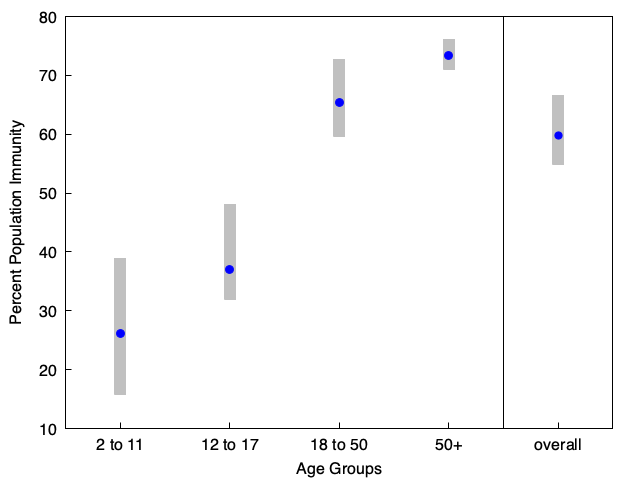

In [300]:
# Plot the Figure

# box plot args: x  box_min  whisker_min  whisker_high  box_high
# can also do # Data columns:X Min 1stQuartile Median 3rdQuartile Max
Gnuplot.options.mime[MIME"text/html"] = "svg enhanced standalone mouse size 350,400";
@gp "reset" 
@gp :- "set boxwidth 0.1 absolute"
@gp :- "set offsets 0.5, 0.5, 0, 0"
@gp :- "set autoscale xfix"
@gp :- "set style fill solid noborder"
@gp :- "set xtics ('2 to 11' 1, '12 to 17' 2, '18 to 50' 3, '50+' 4, 'overall' 5)"

@gp :- "set xtics noenhanced nomirror" # no escaping for strings :-
@gp :- "set ytics nomirror" 
@gp :- "set xlabel 'Age Groups'"
@gp :- "set ylabel 'Percent Population Immunity'"
# obj 1 is the entire plot
#@gp :- "set obj 1 rectangle behind from screen 0,0 to screen 1,1"
#@gp :- "set obj 1 fillstyle solid 1.0 fillcolor rgbcolor 'black'"

@gp :- 1:4 immunities_lo.*100  immunities_lo.*100 immunities_hi.*100   immunities_hi.*100   "w candlesticks notit linecolor rgb 'grey'" 
@gp :- 1:4 immunities_mean.*100 "with point notit pointtype 7 pointsize 1.3  lc rgb 'blue'"
@gp :- 5:5 overall_lo.*100  overall_lo.*100 overall_hi.*100   overall_hi.*100   "w candlesticks notit linecolor rgb 'grey'" 
@gp :- 5:5 overall_mean.*100 "with point notit pointtype 7 pointsize 1.2 lc rgb 'blue'"
#@gp :- "set arrow from 4.5,4 to 4.5,80 nohead lc rgb 'red'"
@gp :- "set arrow from 4.5, graph 0 to 4.5, graph 1 nohead"


In [ ]:
# we want to send simulation to Seyed for plotting the data in Matlab so let's stack the columns and set up multiple files for him

# lets test the stacking 
subdf = stack(finaldf, [:ag1, :ag2, :ag3, :ag4, :ag5, :ag6, :ag7, :ag8, :ag9], [:date, :sim])
filter!(x -> x.variable == string("ag1"), subdf)
subdf = unstack(subdf, :sim, :value)
show(select(subdf, Not([:date, :variable])))

# looks like it works, use for loop to write everything to file
agcolnames = [:ag1, :ag2, :ag3, :ag4, :ag5, :ag6, :ag7, :ag8, :ag9]
for ag in agcolnames 
    subdf = stack(finaldf, [:ag1, :ag2, :ag3, :ag4, :ag5, :ag6, :ag7, :ag8, :ag9], [:date, :sim])
    filter!(x -> x.variable == string(ag), subdf)
    subdf = unstack(subdf, :sim, :value)
    subdf = select(subdf, Not([:date, :variable]))
    CSV.write("$(string(ag))_df.csv", subdf)
end